(CVXPY) Mar 07 06:47:18 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Version of ortools (9.1.9490) is too old. Expected >= 9.3.0.')
(CVXPY) Mar 07 06:47:18 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Version of ortools (9.1.9490) is too old. Expected >= 9.3.0.')
Restricted license - for non-production use only - expires 2023-10-25


d:\Project\SPOProject\SPO\src\function_library.py:88: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.incidence_matrix(self.G, oriented=True).todense() # Return a dense matrix representation of SciPy sparse matrix.


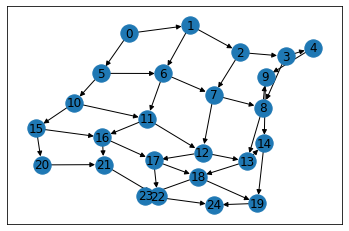

In [1]:
from function_library import *
from reformulation_library import *

different_validation_losses = False
n_holdout = 1000
n_test = 1000
grid_dim = 5
p_features = 5
n_train = 1000
polykernel_degree = 1
polykernel_noise_half_width = 0
d_feasibleregion = 2 * p_features * (p_features - 1)
sources, destinations = convert_grid_to_list(grid_dim, grid_dim)
sp_graph = shortest_path_graph(sources = sources, destinations = destinations,
        start_node = 1, end_node = grid_dim^2, acyclic = True)
B_true = np.array([[bernoulli(0.5) for k in range(p_features)] for e in range(d_feasibleregion)])
X_train, c_train = generate_poly_kernel_data_simple(B_true, n_train, polykernel_degree, polykernel_noise_half_width)
X_validation, c_validation = generate_poly_kernel_data_simple(B_true, n_holdout, polykernel_degree, polykernel_noise_half_width)
X_test, c_test = generate_poly_kernel_data_simple(B_true, n_test, polykernel_degree, polykernel_noise_half_width)
# Add intercept in the first row of X
# an intercept term is a constant term that is added to a linear model to 
# account for the mean or baseline level of the target variable.
# X_train = np.vstack((np.ones(n_train), X_train))
# X_validation = np.vstack((np.ones(n_holdout), X_validation))
# X_test = np.vstack((np.ones(n_test), X_test))

# Solve the shortest path problem
G = define_graph(grid_dim, showflag=False)
solver = Shortest_path_solver(G)
z_train, w_train = batch_solve(solver, c_train)
z_validation, w_validation = batch_solve(solver, c_validation)
z_test, w_test = batch_solve(solver, c_test)

c_ham_train = np.ones((d_feasibleregion, n_train)) - w_train
c_ham_validation = np.ones((d_feasibleregion, n_holdout)) - w_validation
c_ham_test = np.ones((d_feasibleregion, n_test)) - w_test

# Put train + validation together
X_both = np.hstack((X_train, X_validation))
c_both = np.hstack((c_train, c_validation))
c_ham_both = np.hstack((c_ham_train, c_ham_validation))
train_index = np.arange(n_train)
validation_index = np.arange(n_train, n_train + n_holdout)

# Set validation losses
if different_validation_losses:
    spo_plus_val_loss = 'spo_loss'
    ls_val_loss = 'least_squares_loss'
    absolute_val_loss = 'absolute_loss'
else:
    spo_plus_val_loss = 'spo_loss'
    ls_val_loss = 'spo_loss'
    absolute_val_loss = 'spo_loss'

In [2]:
B_soln_list, lambdas = leastSquares_path_jump(X_train, c_train, solver, sp_graph.__dict__, path_alg_parms=PathParms(regularization='lasso'))

In [8]:
np.zeros(40, 5)

TypeError: Cannot interpret '5' as a data type

In [ ]:
num_lambda = 10
lambda_max = None 
lambda_min_ratio = 0.0001 
regularization = 'ridge'
val_alg_parms = ValParms(algorithm_type = 'ls_jump', validation_loss = ls_val_loss)
path_alg_parms = PathParms(num_lambda = num_lambda, lambda_max = lambda_max, 
                                        regularization = regularization,
                                        lambda_min_ratio = lambda_min_ratio, 
                                        po_loss_function = 'leastSquares', algorithm_type = 'leastSquares')
best_B_matrix, best_lambda = validation_set_alg(X_train, c_train, X_validation, c_validation, solver, sp_graph, val_alg_parms, path_alg_parms)

In [ ]:
num_lambda = 10
lambda_max = None 
lambda_min_ratio = 0.0001 
regularization = 'ridge'
path_alg_parms = PathParms(num_lambda = num_lambda, lambda_max = lambda_max, 
                                        regularization = regularization,
                                        lambda_min_ratio = lambda_min_ratio, po_loss_function = 'leastSquares',
                                        algorithm_type = 'leastSquares')
B_soln_list, lambdas = leastSquares_path_jump(X_train, c_train, solver, sp_graph.__dict__, path_alg_parms)